In [309]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

In [310]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Data Preparation

Churn prediction is about identifying customers who are likely to cancel their contracts soon. If the company can do that, it can offer discounts on these services in an effort to keep the users. Here we use the dataset of churn prediction for a telecom company.

- A value of 0 indicates that the customer did not churn (they stayed with the service).
- A value of 1 indicates that the customer did churn (they left the service).

In [311]:
df = pd.read_csv('Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [312]:
df.head(1).T

,0
customerID,7590-VHVEG
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,No
tenure,1
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,No


We see that the dataset has a few columns:
- CustomerID: the ID of the customer
- Gender: male/female
- SeniorCitizen: whether the customer is a senior citizen (0/1)
- Partner: whether they live with a partner (yes/no)
- Dependents: whether they have dependents (yes/no)
- Tenure: number of months since the start of the contract
- PhoneService: whether they have phone service (yes/no)
- MultipleLines: whether they have multiple phone lines (yes/no/no phone service)
- InternetService: the type of internet service (no/fiber/optic)
- OnlineSecurity: if online security is enabled (yes/no/no internet)
- OnlineBackup: if online backup service is enabled (yes/no/no internet)
- DeviceProtection: if the device protection service is enabled (yes/no/no internet)
- TechSupport: if the customer has tech support (yes/no/no internet)
- StreamingTV: if the TV streaming service is enabled (yes/no/no internet)
- StreamingMovies: if the movie streaming service is enabled (yes/no/no internet)
- Contract: the type of contract (monthly/yearly/two years)
- PaperlessBilling: if the billing is paperless (yes/no)
- PaymentMethod: payment method (electronic check, mailed check, bank transfer,
credit card)
- MonthlyCharges: the amount charged monthly (numeric)
- TotalCharges: the total amount charged (numeric)
- Churn: if the client has canceled the contract (yes/no)

When import a CSV file, Pandas tries to guess the right type for each column. But sometimes, it doesn't get it right. So, it's a good idea to double-check the types using ``df.dtypes``.

In [313]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We observe that the `TotalCharges` column poses an issue. Rather than being classified as a numeric type, such as float or integer, pandas incorrectly infers it as an object type.    

In [314]:
# Convert 'TotalCharges' to numeric, replace non-numeric with NaN
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

# Create a filter for NaN values
filter = df['TotalCharges'].isna()

# Display the rows where 'TotalCharges' was NaN
print('Before:')
display(df[filter][['customerID','TotalCharges']].head(2))

# Fill NaN values with zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Display the rows where 'TotalCharges' was NaN before the fillna operation
print('After:')
display(df[filter][['customerID','TotalCharges']].head(2))

Before:


,customerID,TotalCharges
488,4472-LVYGI,NaN
753,3115-CZMZD,NaN


After:


,customerID,TotalCharges
488,4472-LVYGI,0.0
753,3115-CZMZD,0.0


In [315]:
# Columns

# lowering columns name and replace spaces by _
df_columns_lower = df.columns.str.lower()
df.columns  = df_columns_lower.str.replace(' ', '_')

# Rows

# boolean mask for columns with strings
column_mask = df.dtypes == 'object' 
string_columns = list(df.dtypes[column_mask].index)

# lowering rows strings and replace spaces by _
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(2)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no


We see that some columns has 'yes' or 'no' string, that we can convert to boolean. First consider the target variable churn

In [316]:
df.churn = (df.churn == 'yes').astype(int)

df[['customerid', 'churn']].head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
churn,0,0,1,0,1


In [317]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train['churn'].values
y_val = df_val['churn'].values

del df_train['churn']
del df_val['churn']

display(df_train.head(2))

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
2935,9435-jmlsx,male,0,yes,no,71,yes,no,dsl,yes,yes,yes,yes,yes,yes,two_year,yes,bank_transfer_(automatic),86.1,6045.9
3639,0512-flfdw,female,1,yes,no,60,yes,yes,fiber_optic,no,no,yes,no,yes,yes,one_year,yes,credit_card_(automatic),100.5,6029.0


# Exploratory Data Analysis (EDA)

We have already found a problem with the TotalCharges column and replaced the missing values with zeros. Now let’s see if we need to perform any additional null handling:

In [318]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Let’s check the proportion of churned users among all customers. This is the **Global Churn Rate** that refers to the overall churn rate for the entire customer base of the dataset.

For that, we need to divide the number of customers who churned by the total number of customers as follows:

In [319]:
# checking the distribution of values in the target variable
churn_stats = df_train_full['churn'].agg([pd.value_counts])

# Mean
total_values = churn_stats['value_counts'].sum()
churn_stats['global_mean'] = round(churn_stats['value_counts']/total_values, 3)

display(churn_stats)


,value_counts,global_mean
churn,,
0,4113,0.73
1,1521,0.27


This gives us the proportion of churned users, or the probability that a customer will churn. As we see in, approximately 27% of the customers stopped
using our services, and the rest remained as customers. 

Also, the dataset is a imbalanced one. There were three times as many people who didn’t churn in our dataset as those who did churn.

Let's separate the dataset in categorical and numerical variables:

In [320]:
# All categorical columns except 'customerid'
categorical_mask = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[categorical_mask].index)
categorical.remove('customerid') 

# Manually add 'seniorcitizen' because it's an int boolean (0 or 1)
categorical.append('seniorcitizen')
printest('categorical', categorical)

# All numerical columns except 'seniorcitizen' because it's an int boolean
numerical_mask = df_train.dtypes != 'object'
numerical = list(df_train.dtypes[numerical_mask].index)
numerical.remove('seniorcitizen')
printest('numerical', numerical)

categorical : 
 ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen'] 

numerical : 
 ['tenure', 'monthlycharges', 'totalcharges'] 



In [321]:
#Count number of distinct elements in specified axis.
df_train_full[categorical].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

## Feature importance

**Global Churn Rate (mean)**

In the context of the churn dataset, taking the mean of the churn feature effectively calculates the proportion of customers who have churned. This is because the churn feature is binary, meaning that taking its mean provides the proportion (or fraction) of the total customers who have churned. Here, the term 'global' indicates that the rate is calculated over all customers.



In [322]:
# Churn Mean over all costumers
global_mean = df_train_full.churn.mean()
display(global_mean)

0.26996805111821087

**Group Churn Rate (Mean Churn within a Specific Group)**

The Group Churn Rate in the churn dataset represents the average churn specifically for a subset of customers, often defined by certain shared characteristics or attributes. Since the churn feature is binary, this calculated average signifies the proportion of customers in that subset who have churned.

Comparing the Group Churn Rate with the Global Churn Rate offers insights into how a particular subgroup of customers behaves in contrast to the overall customer base. If the Group Churn Rate closely aligns with the Global Churn Rate, it suggests that this group's churn behavior mirrors the overall trend. On the other hand, a significant deviation between the two rates indicates that the group's churn behavior is notably different from that of the overall customers.



Now, let's start our analysis with the gender variable:

In [323]:
# Churn Mean over all Male and Female costumers
gender_mean = df_train_full.groupby('gender')['churn'].mean()
display(gender_mean)

gender
female    0.276824
male      0.263214
Name: churn, dtype: float64

The difference between the group rates for both males and females is quite small, which indicates that knowing the gender of the customer
doesn’t help us identify whether they will churn.

Now let’s take a look at another variable: partner:

In [324]:
# Churn Mean over all partners and not partners costumers
partner_mean = df_train_full.groupby('partner')['churn'].mean()
display(partner_mean)

partner
no     0.329809
yes    0.205033
Name: churn, dtype: float64

The churn rate for people with a partner is significantly less than the rate for the ones without a partner — 20.5% versus 33%. It means that clients with no partner are more likely to churn than the ones with a partner

**Risk Ratio (or Relative Risk)**

As discussed, comparing the Group Churn Rate with the Global Churn Rate provides insights into how a particular subgroup of customers behaves relative to the overall customer base.

This understanding naturally leads to the question: How can we best quantify this deviation or alignment between the Group Churn Rate and the Global Churn Rate? The answer lies in calculating their ratio, termed the Risk Ratio.

$$\text{Risk Ratio} =\frac{\text{Group Churn Rate}}{\text{Global Churn Rate}} $$

The risk ratio can range from zero to infinity. This metric provides a means to measure the degree to which a specific group of customers aligns or diverges from the overall customer tendency.

We can interpret the risk ratio values as follows:

- $\text{Risk Ratio} > 1$: The group has a higher churn rate compared to the overall customers. This implies that members of this group are more likely to churn.

- $\text{Risk Ratio} = 1$: The group's churn rate is equivalent to that of the overall customers, meaning the group's likelihood to churn mirrors that of the overall customers.

- $\text{Risk Ratio} < 1$: The group has a lower churn rate compared to the overall customers. Customers within this group are less likely to churn.
  



In [325]:
# alternative method to groupby
df_group = df_train_full.pivot_table(values = 'churn', index = 'gender', aggfunc = np.mean)
df_group = df_group.rename(columns={'churn': 'mean'})
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean']/ global_mean
display(df_group)

# alternative method to groupby
df_group = df_train_full.pivot_table(values = 'churn', index = 'partner', aggfunc = np.mean)
df_group = df_group.rename(columns={'churn': 'mean'})
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean']/ global_mean


display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


The churn rates for females
and males are not significantly different from the global churn rates, so the risks for them to churn are
low: both have risks values around 1. On the other hand, the churn rate for people with no partner is
significantly higher than average, making them risky, with the risk value of 1.22. People with partners
tend to churn less, so for them, the risk is only 0.75.

for all categorical variables:

In [326]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


- Gender: Little difference in churn rates between females and males, with similar means and risks close to 1 for both groups.

- Senior Citizens: Higher churn risk at 1.53, compared to 0.89 for nonseniors.

- Partner Status: Lower churn risk for customers with a partner at 0.75, compared to 1.22 for those without.

- Phone Service Usage: Near-equal churn risk to global rate for users. Lower risk for non-users, with a risk 
below 1.

- Tech Support: Higher churn risk for clients without tech support with risk 1.55.

- Contract Length: Highest churn risk for monthly contract clients, while two-year contract clients churn very rarely.

## **Entropy**


Consider a hypothetical dataset with multiple features $\mathbf{X_{1}},\cdots \mathbf{X_{l}}, \cdots, \mathbf{X_{d}}$ and a target variable $\mathbf{Y}$. The target variable and some of these features are categorical, meaning each unique value within them corresponds to a distinct category or event.

$$
\left( \begin{array}{c|ccccc|c}
\text{Instance} & \mathbf{X_{1}} & \cdots & \mathbf{X_{l}} & \cdots & \mathbf{X_{d}} & \mathbf{Y} \\
\hline
\mathbf{x_{1}} & x_{11} & \cdots & x_{1l} & \cdots & x_{1d} & y_1 \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots \\
\mathbf{x_{n}} & x_{n1} & \cdots & x_{nl} & \cdots & x_{nd} & y_n \\
\end{array} \right).
$$

Here, each row vector $ \mathbf{x}_i = (x_{i1}, \ldots, x_{id}) $ represents an instance of the dataset with $ d $ values. We take from this dataset one feature vector $\mathbf{X}_l$ with categorical values and a target vector $\mathbf{Y}$ as follows:


$$\mathbf{X}_l= \left( \begin{array}{c}
x_{1l}\\
\vdots\\
x_{nl}
\end{array} \right)  ~~~~~

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The concept of entropy arises from information theory. It is a measure that captures the amount of uncertainty or randomness in a variable. 

When considering a categorical feature $ \mathbf{X}_l $ as a random variable, entropy helps us understand the unpredictability in the unique categories it can adopt. Let's denote the set of unique categories in $ \mathcal{X}=  \{a_1, a_2, \ldots, a_k\} $ where $ k $ is the number of unique categories. If the probabilities of these categories occurring are $ p(a_1), p(a_2), \ldots, p(a_k) $, then the entropy $ H(\mathbf{X}_l) $ is given by:


$$H(\mathbf{X}_l) = \mathbb{E}_{x \in \mathcal{X}}[-\log{p(x)}] = -\sum_{x \in \mathcal{X}} p(x)\log{p(x)} $$

The formula includes a negative sign to guarantee a non-negative entropy value. In the context of data analysis, a feature with high entropy implies a greater diversity in the distribution of its categories, leading to a decrease in prediction certainty. On the other hand, low entropy indicates a degree of homogeneity in its classes, making the feature values more predictable (less random).

From the entropy formula, we can think $ H(\mathbf{X}_l) $ as encapsulating the average uncertainty experienced when a value from $ \mathbf{X}_l $ is observed. Each category $x$ in $ \mathcal{X} $ has an associated information content — or uncertainty factor — given by $ p(x)\log{p(x)} $. By averaging these across all categories, entropy essentially conveys the expected level of surprise.

## **Conditional Entropy**

Conditional entropy extends the concept of entropy to measure the unpredictability of one variable, given knowledge about another. In this context, we wish to understand this with respect to our feature vector $ \mathbf{X}_l $ and target vector $ \mathbf{Y} $.


Instead of using the ordinary probability $ p(x) $ as before, we can use the conditional probability. Let's denote the set of unique categories from $\mathbf{Y}$ as $ \mathcal{Y} =  \{b_1, b_2, \ldots, b_m\} $ with the probabilities of these categories occurring being $ p(b_1), p(b_2), \ldots, p(b_m) $. Then, the conditional probability is denoted as $p(\mathbf{X}_l|\mathbf{Y} = y)$. Given this, we can compute the conditional entropy of $\mathbf{X}_l$ for a fixed state $ y \in \mathcal{Y}$ as:
 

$$H(\mathbf{X}_l|\mathbf{Y} = y) = \mathbb{E}_{x \in \mathcal{X}}[-\log{p(x|y)}] = - \sum_{x \in \mathcal{X}} p(x|y)\log p(x|y) $$

To relate this to joint probabilities, consider the following definitions:

---

- **Joint probability**:Let $x \in \mathcal{X} = \{a_1, a_2, \ldots, a_k\} $ and $y \in \mathcal{Y} = \{b_1, b_2, \ldots, b_m\} $. If $N(x)$ symbolizes the count of occurrences of event $x$, and $N(x \cap y)$ the simultaneous occurrence of events $x$ and $y$, the joint probability can be formulated as:

    $$
    p(x \cap y) = \frac{N(x \cap y)}{N}
    $$

    Here, $N $ is the total number of events.

- **Conditional probability**:
    It describes the probability of event $x$ occurring given that event $y$ has already occurred. The conditional probability of event $x$ given event $y$ is then defined as:

    $$p(x|y) = \frac{p(x \cap y)}{p(y)}.$$

    where $p(y)$ is the ordinary probability of some event $y$ happening,

    $$p(y) = \frac{N(y)}{N}.$$
---

Given theses briefly definition, we can use the following relationship,

$$p(x|y) = \frac{p(x \cap y )}{p(y)},$$

to express the conditional entropy as:

$$H(\mathbf{X}_l|y) = - \sum_{x \in \mathcal{X}} \frac{p(x \cap y)}{p(y)}\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg) $$ 

Here we simplified the notation of entropy $H(\mathbf{X}_l|\mathbf{Y} = y)$ to $H(\mathbf{X}_l|y)$. 

To fully evaluate the conditional entropy across all values of $\mathbf{Y}$, we can take again the expectation value over all possible values from $\mathbf{Y}$, as we did before for values of $\mathbf{X}_l$. Given the expected value we get:

$$ \mathbb{E}_{y \in \mathcal{Y}}[H(\mathbf{X}_l| y)] = H(\mathbf{X}_l|\mathbf{Y}) = - \sum_{{y \in \mathcal{Y}}} p(y)H(\mathbf{X}_l|y) $$


substituting $H(\mathbf{X}_l| y)$ into the equation, we get:

$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= - \sum_{y \in \mathcal{Y}} p(y)H(\mathbf{X}_l|y) \\
       &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(y)\bigg[\frac{p(x \cap y)}{p(y)}\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg)\bigg]\\
       &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} p(x \cap y)\log \bigg(\frac{p(x \cap y)}{p(y)}\bigg)
\end{align*}
$$

This computation yields the expected conditional entropy over all possible outcomes of $\mathbf{Y}$. But this equation can be further rearranged using logarithm properties to obtain:


$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}} \bigg[ p(x \cap y)\log{p(x \cap y)} -    p(x \cap y)\log{p(y)}\bigg] \\
    &= - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}  p(x \cap y)\log{p(x \cap y)} +\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}    p(x \cap y)\log{p(y)}\\
    &= H(\mathbf{X}_l \cap \mathbf{Y}) + \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}    p(x \cap y)\log{p(y)}

\end{align*}
$$

Now, for the second summation term, from the law of total probability, we have

$$p(y) = \sum_{x \in \mathcal{X}} p(x|y)p(y)$$

then, using one more time the relationship $p(x \cap y ) = p(x|y)p(y) $  and the total law 

$$
\begin{align*}
H(\mathbf{X}_l|\mathbf{Y}) &= H(\mathbf{X}_l \cap \mathbf{Y}) + \sum_{y \in \mathcal{Y}} \bigg[\sum_{x \in \mathcal{X}} p(x|y)p(y)\bigg] \log{p(y)}\\
       & = H(\mathbf{X}_l \cap \mathbf{Y}) +  \sum_{y \in \mathcal{Y}}p(y)\log{p(y)}
\end{align*}
$$

The second term simplify to the negative entropy $-H(\mathbf{Y})$

$$H(\mathbf{X}_l|\mathbf{Y}) = H(\mathbf{X}_l \cap \mathbf{Y} ) - H(\mathbf{Y}) $$


This represents the average uncertainty about $\mathbf{X}_l$ once knowledge about $\mathbf{Y}$ is accounted for.

## **Mutual information**

Mutual information was introduced to quantify how much information knowing one variable gives about another.

A straightforward way to think about this is to measure how much the entropy (uncertainty) of $\mathbf{X}_l$  reduces when $\mathbf{Y}$ is known. This is given by the difference between the entropy of $\mathbf{X}_l$ and the conditional entropy of $\mathbf{X}_l$ given $\mathbf{Y}$:

$$MI(\mathbf{X}_l;\mathbf{Y}) = H(\mathbf{X}_l) − H(\mathbf{X}_l|\mathbf{Y})$$

Thus mutual information quantifies the amount of information gained about $\mathbf{X}_l$ after learning about $\mathbf{Y}$, and the amount of information gained about $\mathbf{Y}$ after learning about $\mathbf{X}_l$. This is because mutual information is symmetric, i.e., $MI(\mathbf{X}_l;\mathbf{Y}) = MI(\mathbf{Y};\mathbf{X}_l)$.

Here's how to interpret mutual information:

- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is high:** A high value of mutual information means a value closer to  $H(\mathbf{X}_l)$ or $H(\mathbf{Y})$.  knowing $\mathbf{Y}$ reduces our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ reduces our uncertainty about $\mathbf{Y}$. This is the case where $\mathbf{X}_l$ and $\mathbf{Y}$ have some dependency.
 
- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is zero:**  knowing $\mathbf{Y}$ does nothing to decrease our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ does nothing to decrease our uncertainty about $\mathbf{Y}$. This is the case when $\mathbf{X}_l$ and $\mathbf{Y}$ are independent.

In [327]:
def  entropy_metrics(feature, target):

    def entropy(feature):

        unique, n_x = np.unique(feature, return_counts= True)
        n = len(feature)
        p_x = n_x/n
        # Only consider non-zero probabilities to avoid log(0)
        p_x = p_x[p_x > 0]
        H_x = -np.sum(p_x * np.log(p_x))
        return H_x

    def joint_entropy(feature, target):
        
        # frequency distribution of their joint occurrences.
        joint_freq = pd.crosstab(feature, target)
        # .sum().sum() calculate total sum across both rows and columns.
        n = joint_freq.sum().sum()
        # joint probabilities by dividing each frequency by the total count
        joint_prob = joint_freq/n
        # Sum across rows and columns for the final joint entropy value.
        joint_entropy = - np.sum(np.sum(joint_prob[joint_prob > 0] * np.log(joint_prob[joint_prob > 0])) )
        
        return joint_entropy

    def conditional_entropy(feature, target):
        return joint_entropy(feature, target) - entropy(target)
    

    def mutual_info(feature, target):
        return entropy(feature) -  conditional_entropy(feature, target)
    
    results = {
        'entropy': entropy(feature),
        'joint_entropy': joint_entropy(feature, target),
        'conditional_entropy': conditional_entropy(feature, target),
        'mutual_information': mutual_info(feature, target)
    }

    return results

In [328]:
# Select categorical features
is_categorical = df_train_full.dtypes == 'object'
categorical = list(df_train_full.dtypes[is_categorical].index)

# Create an empty list to store results
mi_results = []
for feature in categorical:
    metric = entropy_metrics(df_train_full[feature], df_train_full['churn'])
    # Append a tuple containing feature name and its mutual info
    mi_results.append((feature, round(metric['mutual_information'], 3)))

mutual_info_df = pd.DataFrame(mi_results, columns=['features', 'mutual_info']).sort_values(by = 'mutual_info',ascending=False)

#display(mutual_info_df)

print("Hight values of MI:")
display(mutual_info_df.head())
print("\n Low values of MI:")
display(mutual_info_df.tail())

Hight values of MI:


,features,mutual_info
0,customerid,0.583
13,contract,0.098
7,onlinesecurity,0.063
10,techsupport,0.061
6,internetservice,0.056



 Low values of MI:


,features,mutual_info
3,dependents,0.012
2,partner,0.010
5,multiplelines,0.001
1,gender,0.000
4,phoneservice,0.000


In [329]:
# We can also use mutual_info_score from sklearn
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

# Apply a function along one of the axis
df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

print("Hight values of MI:")
display(df_mi.head())
print("\n Low values of MI:")
display(df_mi.tail())

Hight values of MI:


,MI
customerid,0.583227
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868



 Low values of MI:


,MI
dependents,0.012346
partner,0.009968
multiplelines,0.000857
phoneservice,0.000229
gender,0.000117


As we see, contract, onlinesecurity, and techsupport are among the most
important features. It’s not surprising that gender is among the least important features, so we shouldn’t expect it to be useful for the model.

## Numerical variables

**Pearson's correlation coefficient**

While mutual information can effectively quantify the degree of dependency between two categorical variables, it doesn't function well when one of the variables is numerical. Hence, it isn't appropriate for the three numerical variables in our dataset.

Instead, Pearson's correlation coefficient can be used as a measure of the linear correlation or dependence between two variables, X and Y. The coefficient provides a value between $[1, −1]$, where:

- 1 is a total positive linear correlation, 
- 0 is no linear correlation
- −1 is a total negative linear correlation. 

the correlation for a pair of random variables $(X, Y)$ is given by:

$$
\rho(X,Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}
$$

In this equation, $\text{cov}(X,Y)$ represents the covariance between X and Y, while $\sigma_X$ and $\sigma_Y$ are the standard deviations of X and Y, respectively. The covariance, a measure of how much two random variables change together, is computed as follows:

$\text{cov}(X,Y) = E[(X - E[X])(Y - E[Y])]$

Here, $E[X]$ and $E[Y]$ are the expected values (or means) of X and Y, respectively. This formula essentially captures the joint variability of X and Y.

The standard deviations, which measure the dispersion or spread of the data points from the mean, are computed as follows:

$$\sigma_X = \sqrt{E[X^2] - E[X]^2}$$
$$\sigma_Y = \sqrt{E[Y^2] - E[Y]^2}$$

Pearson's correlation coefficient can be a valuable tool to understand and visualize the linear relationships between features. This can inform feature selection, as highly correlated features often carry redundant information

Let's translate this to python code:

In [330]:
def pearson_corr(x, y):
    # Compute the means of X and Y
    mean_x = x.agg(np.mean)
    mean_y = y.agg(np.mean)
    
    mean_x_values = mean_x.values
    x_labels = mean_x.index
    x_values = x.values

    mean_y = y.agg(np.mean)
    y_values = y.values.reshape(-1,1)

    # Compute the covariance
    cov_XY = np.mean((x_values - mean_x_values) * (y_values - mean_y), axis = 0)

    # Compute the standard deviations
    std_X = np.sqrt(np.mean((x_values - mean_x_values)**2, axis = 0))
    std_Y = np.sqrt(np.mean((y_values - mean_y)**2, axis = 0))

    # Compute the correlation
    corr_XY = cov_XY / (std_X * std_Y)

    # Create the DataFrame
    corr_XY = pd.DataFrame(corr_XY, index=x_labels, columns=['pearson_correlation'])
    return corr_XY

In [331]:
def pearson_corr_matrix(df):

    # Select numeric features
    is_numeric = df.dtypes != 'object'
    numerical = list(df.dtypes[is_numeric].index)
    
    n = len(numerical)
    corr_matrix = np.zeros((n, n))

    for i, feature_i in zip(range(n), numerical ):
        for j, feature_j in zip(range(n), numerical ):
            # Select numerical features x and y
            x = df[feature_i]
            y = df[feature_j]

            # compute the means 
            mean_x = np.mean(x)
            mean_y = np.mean(y)

            # Compute the covariance
            cov_XY = np.mean((x - mean_x) * (y - mean_y))
            # Compute the standard deviations
            std_X = np.sqrt(np.mean((x - mean_x)**2))
            std_Y = np.sqrt(np.mean((y - mean_y)**2))
            
            # Compute the correlation of features x and y
            corr_matrix[i, j] = cov_XY / (std_X * std_Y)
    
    return pd.DataFrame(corr_matrix, index=numerical, columns=numerical)

In [332]:
correlation_matrix = pearson_corr_matrix(df_train_full)
correlation_matrix

,seniorcitizen,tenure,monthlycharges,totalcharges,churn
seniorcitizen,1.000000,0.023443,0.225234,0.110459,0.141966
tenure,0.023443,1.000000,0.251072,0.828268,-0.351885
monthlycharges,0.225234,0.251072,1.000000,0.650913,0.196805
totalcharges,0.110459,0.828268,0.650913,1.000000,-0.196353
churn,0.141966,-0.351885,0.196805,-0.196353,1.000000


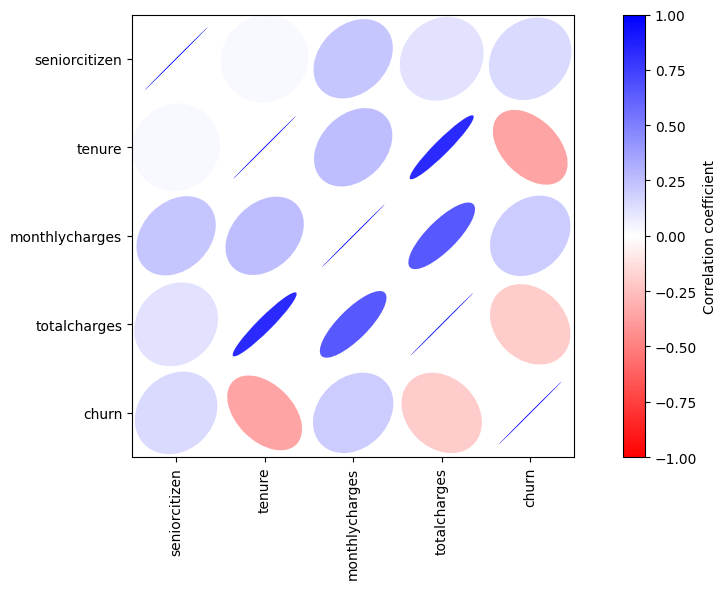

In [333]:
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(correlation_matrix, figsize=(10, 6), cmap='bwr_r')
cb = plt.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

As we can see: 

- `tenure` has a high negative correlation (-0.35): as tenure grows, churn rate goes down. 

- `monthlycharges` has positive correlation (0.19): the more customers pay, the more likely they are to churn

In [334]:
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2548.021627
1,18.070348,74.521203,1545.689415


# Feature engineering

## One-hot encoding

When dealing with a categorical variable like "contract" with multiple possible values (e.g., monthly, yearly, and two-year), we can use a technique called one-hot encoding to represent each value as a binary vector. In this case, if we have a customer with a yearly contract, the one-hot encoding representation would be (0, 1, 0).

This encoding scheme works by designating the "active" or "hot" value as 1, while the other values are considered "not active" or "cold" and assigned a value of 0. In our example, the yearly contract is the active value, so it receives a 1, while the monthly and two-year contracts are not active and receive 0.

In [335]:
#Transform dataframe in dict inside a list
train_dict = df_train[categorical + numerical].to_dict(orient='records')
train_dict[0]

{'customerid': '9435-jmlsx',
 'gender': 'male',
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

In [336]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

X_train[0].shape

(3818,)

In [337]:
# Shows only first three features after hot encoding
dv.get_feature_names_out()[:3]

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year'], dtype=object)

# **Logistic Regression**

Consider a hypothetical dataset with multiple features $\mathbf{X}_{1},\cdots, \mathbf{X}_{d}$ and a target variable $\mathbf{Y}$ as shown:

$$
\left( \begin{array}{c|cccc|c}
\text{Instance}    &\mathbf{X}_{0}&\mathbf{X}_{1}&\cdots & \mathbf{X}_{d}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

Here, each row vector is an instance $\mathbf{x}_i = (1, x_{i1}, \ldots, x_{id})$ of the dataset with $ d+1 $ values. The first column, $ \mathbf{X}_0 $, is the intercept term (or bias) and is set to $1$ for all instances. The dataset is separated in a feature matrix $\mathbf{X}$ and a binary target vector $\mathbf{Y}$:


$$\mathbf{X}=
\left( \begin{array}{cccc}
 1& x_{11}& \cdots&x_{1d} \\
\vdots&\vdots&\ddots&\vdots&\\
1&x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~ 

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The target vector $\mathbf{Y}$ consists of binary values, either 0 or 1, hence forming the set $\mathcal{Y}=\{0,1\}$.

Since there are only two possible unique values for $Y$, the conditional probabilities can be defined as:

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \pi( \mathbf{x}_i) ~~\text{and}~~~p(\mathbf{Y} = 0|\mathbf{X}= \mathbf{x}_i) = 1- \pi( \mathbf{x}_i)$$

This notation indicates that we're looking at the conditional probability of $ \mathbf{Y} $ being 1 given a specific instance $ \mathbf{x}_i $. Here, $ \pi( \mathbf{x}_i) $ represents an unknown function of the instances. Our primary objective in logistic regression is to estimate this function, $ \pi( \mathbf{x}_i) $, which essentially defines our logistic regression model.

A naive approach would be to directly use linear regression for the function $ \pi( \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}$, where $\mathbf{w} = (w_0, \ldots, w_d)^T$ is the weights that will be learned by the model. This would  result in

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}.$$

However due to the fact that $\mathbf{x}_i\mathbf{w}$ can assume values in the range $(- \infty,+ \infty)$ is not possible to use as a probability model. We require that the output represents a probability values, and thus we need a model that results in an output that lies in the range $[0,1]$. For this task we rely in the sigmoid function, this function is also know as logistic function. The logistic function is defined as follows:

---

- **Sigmoid**
    $$\theta(z) = \frac{1}{1+e^{-z}} = \frac{e^{z}}{1+e^{z}}$$

    for any $z \in \mathbb{R}$ the output is $\theta(z) \in [0,1]$. An interesting property of the logistic function is that $1 - \theta(z) = \theta(-z)$:

$$1-\theta(z) = 1 - \frac{1}{1+ e^{-z}} = \frac{e^{-z}}{1+ e^{-z}} = \frac{1}{1+ e^{z}} =  \theta(-z)~~\square$$
---
We now can maps this linear combination $\mathbf{x}_i\mathbf{w}$ through the logistic (sigmoid) function to get a value that represents a probability between 0 and 1. We can address the probability as $p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})$ and define the logistic regression model as follows:

$$
\begin{align*}
p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) &= \theta(\mathbf{x}_i\mathbf{w}) \\
&= \frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}~~~\text{and}\\
\\
p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) &= 1 - p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i)\\
&= \frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\\
& = \theta(-\mathbf{x}_i\mathbf{w})
\end{align*}
$$

where in $p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i)$ we use the property $1 - \theta(z) = \theta(-z)$. The model then can be formulated from the following probability:

$$p(\mathbf{Y}|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})^{y}\theta(-\mathbf{x}_i\mathbf{w})^{1-y}$$

where $y \in \mathcal{Y} = \{0,1\}$, which can be considered a Bernoulli random variable that takes on either the values 0 or 1. We can observe that 


$$ p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w}) ~~\text{and} ~~ p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) = \theta(-\mathbf{x}_i\mathbf{w})$$ 

**Maximum Likelihood Estimation**

In logistic regression, we use the maximum likelihood estimation (MLE) approach to find the optimal weight vector, $ \mathbf{w} = (w_0, \ldots, w_d)^T $. The likelihood function quantifies how well our model, parameterized by $ \mathbf{w} $, explains the observed data. Consider the joint probability of observing the entire target vector $ \mathbf{Y} $ given the feature matrix $ \mathbf{X} $ under a particular parametrization $ \mathbf{w} $:

$$ \mathcal{L}(\mathbf{w}) = p(\mathbf{Y}|\mathbf{X}; \mathbf{w} ) = P(y_1, \ldots, y_n|\mathbf{x}_1, \ldots, \mathbf{x}_n; \mathbf{w} ) $$

If we assume that the observed outcomes in vector $\mathbf{Y}$, given their corresponding features in matrix $\mathbf{X}$, are conditionally independent given the model parameters $\mathbf{w}$, then we can factorize the likelihood of the entire dataset as the product of the likelihoods of each individual observation:

$$ \mathcal{L}(\mathbf{w}) = \prod_{i=1}^{n} P(y_i|\mathbf{x}_i; \mathbf{w} )  $$

Each term $ P(y_i|\mathbf{x}_i; \mathbf{w} ) $ represents the probability that instance $ i $ belongs to its observed class given its features and the model parameters. Substituting the logistic model into the likelihood we get

$$\mathcal{L}(\mathbf{w}) =  \prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}$$

Our aim is to find the value of $\mathbf{w}$ that maximizes this likelihood, an approach known as Maximum Likelihood Estimation (MLE). In practice, we often maximize the logarithm of the likelihood (log-likelihood) to convert the product into a sum:

$$
\begin{align*}
\log(\mathcal{L}(\mathbf{w})) & = \log \left(\prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}\right) \\
& = \sum_{i = 1}^{n} y_i\log(\theta(\mathbf{x}_i\mathbf{w})) + (1-y_i)\log(\theta(-\mathbf{x}_i\mathbf{w}))
\end{align*}
$$

Substituting the logistic function into this equation further simplifies it:

$$\log(\mathcal{L}(\mathbf{w})) = \sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) + (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

Typically in optimization, we don't maximize this log-likelihood directly. Instead, we minimize the negative of this quantity, which is called the log-loss or cross-entropy loss function. This function serves as a loss function during training:

$$\text{loss}(\mathbf{w}) = -\log(\mathcal{L}(\mathbf{w})) = -\sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) - (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

This cross-entropy loss comes directly from the negative log-likelihood of the Bernoulli distribution, and this is why it's appropriate for binary classification problems like this one. It measures the dissimilarity between the ground-truth labels and the predicted probabilities. The better our predictions, the lower the cross-entropy loss.

To obtain the optimal weights vector $\mathbf{w}$, we would typically differentiate the log-likelihood function with respect to $\mathbf{w}$, equate the result to zero, and then solve for $\mathbf{w}$. However, unlike linear regression, the log-likelihood formulation lacks a closed form solution for the weight vector. Instead, we use methods like gradient ascent due to the concavity of the log-likelihood function, which ensures a unique global maximum. After calculating the optimal weights, we can use the model equation to make prediction.



In [338]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [339]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)

The first column of the array contains the probability that the target is negative
(no churn), and the second column contains the probability that the target is positive
(churn).

To make the actual decision about whether to send a promotional letter to our customers,
using the probability alone is not enough. We need hard predictions — binary
values of True (churn, so send the mail) or False (not churn, so don’t send the mail). To get the binary predictions, we take the probabilities and cut them above a certain
threshold. If the probability for a customer is higher than this threshold, we predict
churn, otherwise, not churn. If we select 0.5 to be this threshold, making the
binary predictions is easy.

In [340]:
p = y_pred[:,1]
churn = p > 0.5
printest('prediction of clients that churn:',churn)
printest('clients that churn:',y_val)



prediction of clients that churn: : 
 [False False False ... False  True False] 

clients that churn: : 
 [0 1 0 ... 0 0 0] 



In [341]:
# True if our prediction is correct and False if it’s not.
printest('predictions', y_val == churn)
accuracy = (y_val == churn).mean()
printest('accuracy', accuracy)

predictions : 
 [ True False  True ...  True False  True] 

accuracy : 
 0.7994623655913978 



The result from the mean is the fraction of ones in that array, which we already used
for calculating the churn rate. Because “1” (True) in this case is a correct prediction and “0” (False) is an incorrect prediction, the resulting number tells us the percentage of correct predictions.

An accuracy of 0.80 means that the model
predictions matched the actual value 80% of the time, or the model makes correct
predictions in 80% of cases.

# Model interpretation

For logistic regression the model learn from the overall data a vector of weights $\mathbf{w} = (w_1, \cdots, w_n)$ and the bias term $w_0$. Let's get the vector of weights and correlate with the respective features they represent.

In [342]:
feature_names = dv.get_feature_names_out()
weights = model.coef_[0]

# First five features and respective weights
list(zip(feature_names, weights.round(3)))[:5]

[('contract=month-to-month', 0.558),
 ('contract=one_year', -0.115),
 ('contract=two_year', -0.566),
 ('customerid=0002-orfbo', -0.006),
 ('customerid=0013-exchz', 0.01)]

Let's use a small set of features, contract (categorical), tenure (numeric) and totalcharges(numeric). For the contract features is necessary to use one hot encoder as follows:

In [343]:
subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[subset].to_dict(orient = 'records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)
X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

printest('Bias:',model_small.intercept_[0])
printest('Weights',dict(zip(dv_small.get_feature_names_out(),model.coef_[0].round(3))))

Bias: : 
 -0.6387618613273348 

Weights : 
 {'contract=month-to-month': 0.558, 'contract=one_year': -0.115, 'contract=two_year': -0.566, 'tenure': -0.006, 'totalcharges': 0.01} 



| Bias| Contract month|Contract year|Contract 2 year| tenure | charges|
| --- | --- | --- |--- |--- |--- |
| $ -0.577$ | $0.563$ | $-0.086$ |  $-0.599$ |  $-0.03$ | $-0.092 $|

In linear regression, the bias term denotes the model's baseline prediction when there's no information about the other variables. In logistic regression, the model's interpretation becomes more complex due to the implementation of the sigmoid function before producing the final output. Let's illustrate this with the features: contract month ($X_{1}$), contract year ($X_{2}$), contract for 2 years ($X_{3}$), tenure ($X_{4}$), and charges ($X_{5}$).

We can represent these as a feature matrix $\mathbf{X}$, as did before, with ${X}_{0}$ set to one for the bias. Similarly, let's denote the weights as $\mathbf{w} = (w_0,w_1,w_2,w_3,w_4,w_5)^T$. In linear regression, the predicted target variable $\mathbf{\hat{y}}$ for $\mathbf{X}$ is given by

$$\mathbf{\hat{y}} = \mathbf{X}\mathbf{w} $$

For each individual customer, we could write this for each instance from the dataset

$$\mathbf{\hat{y}}_i = \mathbf{x}_i\mathbf{w}.$$

Now, for logistic regression, we interpret the weights differently. After applying the sigmoid function, we obtain:

$$P(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{\hat{y}}_i)= \frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}$$

This calculates the probability of the $i^{th}$ customer churning. The bias term signifies the baseline prediction of the model. If we set all the feature values to zero, except for $x_0 = 1$ which corresponds to the bias, we derive:
$$P(\mathbf{Y} = 1|\mathbf{X} = x_0 = 1) = \frac{e^{w_0}}{1+ e^{w_0}}$$

In our specific problem, we have $w_0 = -0.577$, yielding a churn probability of $Pr = 0.36 $. In other words, without specific knowledge about a customer's features, our model's default assumption is that there's a 36% chance they will churn, suggesting that a generic customer is more likely to stay with the service than to leave.

# Using the model

We applied the model to the validation set, computed the probabilities
of churning for every customer there, and concluded that the model is 80% accurate.

In [344]:
accuracy = (y_val == churn).mean()
printest('accuracy', accuracy)

accuracy : 
 0.7994623655913978 



To evaluate the model we can take a random customer from the test dataset as follows:

In [345]:
#Transform dataframe in dict inside a list
test_dict = df_test[categorical + numerical].to_dict(orient='records')
i = int(np.random.randint(df_test.shape[0], size =1))
customer = test_dict[i]
X_test = dv.transform([customer])

y_pred = model.predict_proba(X_test)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.59894119 0.40105881]] 

